In [1]:
import splitfolders
import os

import video_preprocess as vp
import config as conf
import models
import anomaly_detection as ad
import visualization as vis
import evaluate

import matplotlib.pyplot as plt

2023-01-03 14:20:08.075351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train-Val-Test Split
dataset download link: https://www.kaggle.com/datasets/robikscube/driving-video-with-object-tracking

downloaded dataset must be placed as is in the same folder as this notbook!

In [ ]:
# rename folder
os.rename('./driving-video-with-object-tracking/bdd100k_videos_train_00/bdd100k/videos/train', 
          './driving-video-with-object-tracking/bdd100k_videos_train_00/bdd100k/videos/videos')
splitfolders.ratio('./driving-video-with-object-tracking/bdd100k_videos_train_00/bdd100k/videos/videos/',
                   output="datasets",
                   seed=1337,
                   ratio=(.8, 0.1,0.1)) 

### Get Datasets

In [2]:
def get_dataset(dataset_name, N_FRAMES, training, num_videos=-1, stack_videos=False, noisy_video_probability=0.2):
    fg = vp.FrameGenerator(conf.DATA_PATHS[dataset_name], N_FRAMES, training, noisy_video_probability=noisy_video_probability)
    return fg.generate_frames_array(num_videos, stack_videos)

In [3]:
train_frames, _, _ = get_dataset('train',
                                 conf.N_FRAMES,
                                 training=True,
                                 num_videos=-1,
                                 )

val_frames, val_target, val_noise_types = get_dataset('val',
                                                      conf.N_FRAMES,
                                                      training=False,
                                                      num_videos=-1,
                                                      noisy_video_probability=conf.NOISE_VIDEO_PROBABILITY_VAL)

test_frames, test_target, test_noise_types = get_dataset('test',
                                                      conf.N_FRAMES,
                                                      training=False,
                                                      num_videos=-1,
                                                      noisy_video_probability=conf.NOISE_VIDEO_PROBABILITY_TEST)


2023-01-03 14:20:13.724723: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


##### Show sample of noisy images

Validation Noisy Images Count: 52


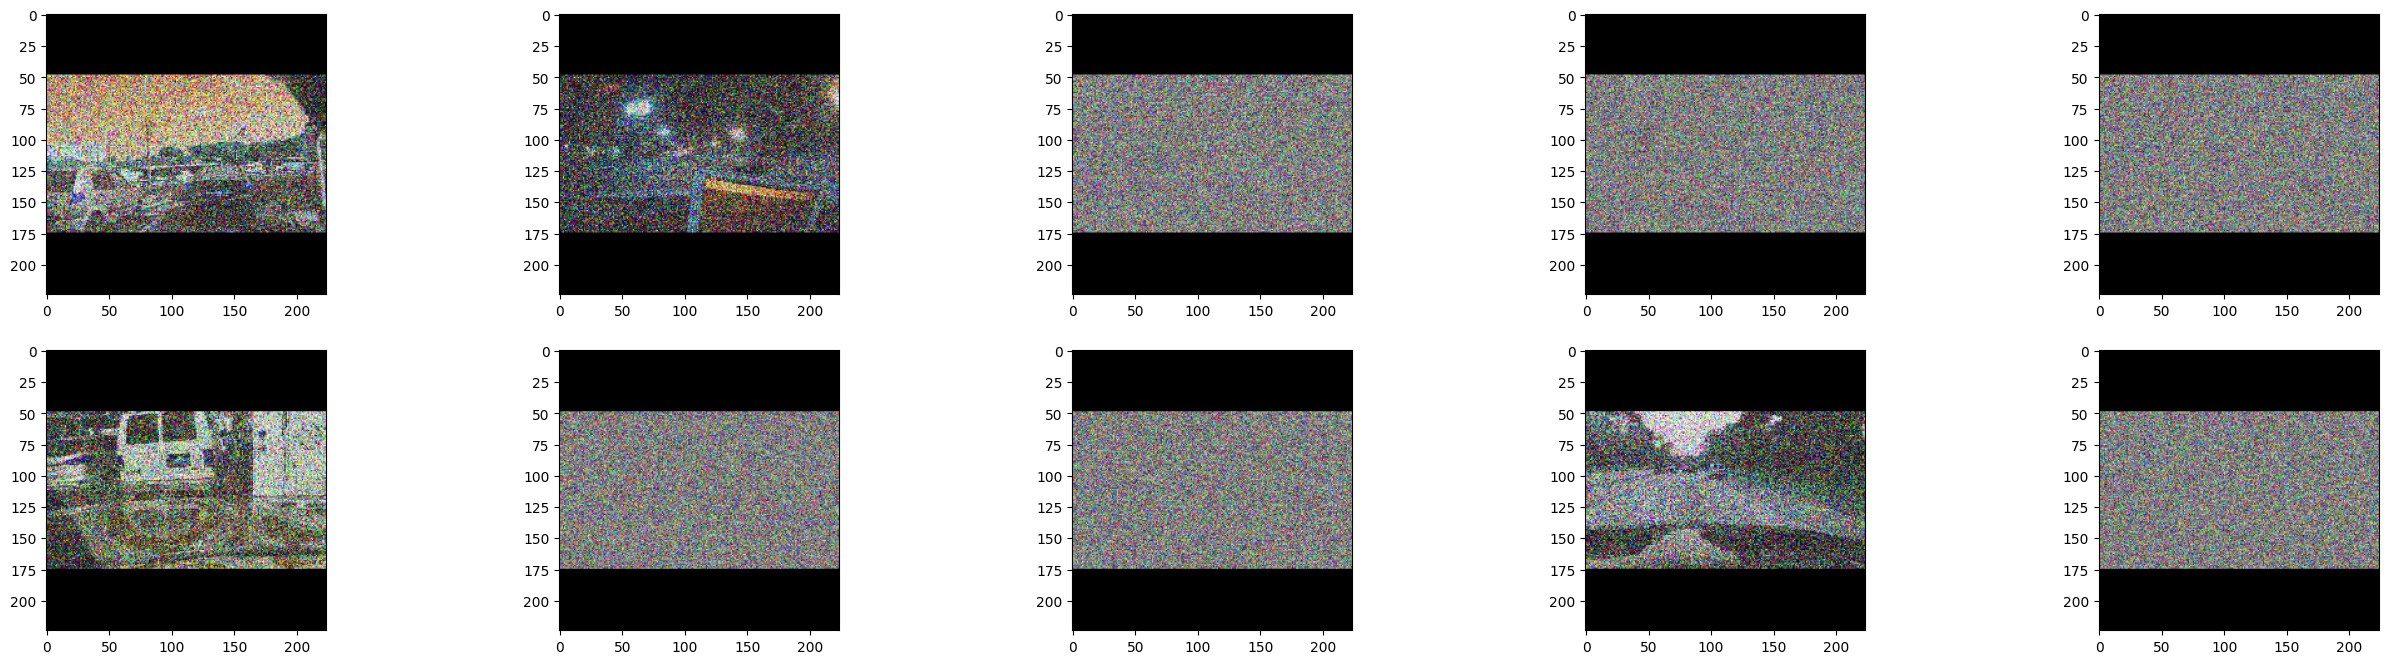

In [12]:
print(f'Validation Noisy Images Count: {len(val_frames[[bool(t) for t in val_target]])}')
vis.plot_frames(val_frames[[bool(t) for t in val_target]], 2,5)

##### Dist of noise types over validation set

(array([15.,  0.,  0.,  0.,  0., 23.,  0.,  0.,  0., 14.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

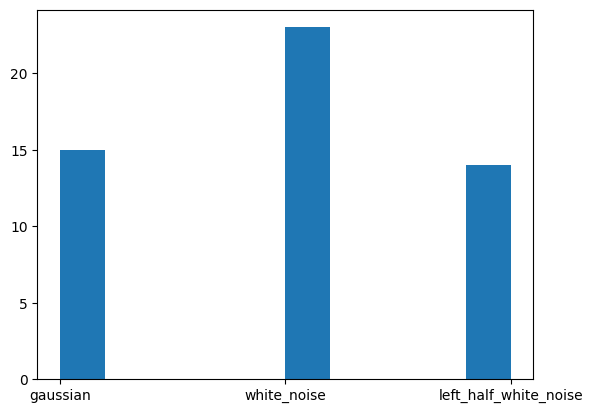

In [13]:
plt.hist(val_noise_types[val_noise_types != 'OriginalData'], label="Validation - noise type dist")

##### Dist of noise types over test set

Test Noisy Images Count: 48


(array([12.,  0.,  0.,  0.,  0., 20.,  0.,  0.,  0., 16.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

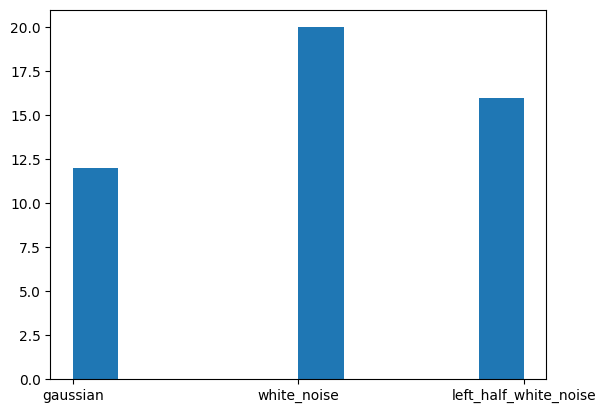

In [14]:
print(f'Test Noisy Images Count: {len(test_frames[[bool(t) for t in test_target]])}')
plt.hist(test_noise_types[test_noise_types != 'OriginalData'], label="Test - noise type dist")

## Models

<b>Option 1: CAE (Convolutional AutoEncoder)
   
    treat all frames as standalone images and find noise images (relevant only to random noise frame not for real images inserted accidentaly)

#### Load Trained Model

In [7]:
CAE = models.get_model('CAE', load_model=True)

#### Train Model

In [59]:
CAE = models.get_model('CAE', load_model=False)

callbacks = [
    # saves the model's weights
    tf.keras.callbacks.ModelCheckpoint(
        filepath=conf.MODELS_PATHS.get('CAE'),
        save_weights_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        min_delta=1e-3, 
        patience=2,
        verbose=1,
    )
]

CAE_history = CAE.fit(train_frames, train_frames,
                      epochs=10,
                      batch_size=100,
                      validation_data=(val_frames, val_frames),
                      callbacks=callbacks
                      )


Epoch 1/10
80/80 [==============================] - ETA: 0s - loss: 0.0583
Epoch 1: saving model to ./training_CAE/cp.ckpt
80/80 [==============================] - 391s 5s/step - loss: 0.0583 - val_loss: 0.0083
Epoch 2/10
80/80 [==============================] - ETA: 0s - loss: 0.0059
Epoch 2: saving model to ./training_CAE/cp.ckpt
80/80 [==============================] - 391s 5s/step - loss: 0.0059 - val_loss: 0.0065
Epoch 3/10
80/80 [==============================] - ETA: 0s - loss: 0.0050
Epoch 3: saving model to ./training_CAE/cp.ckpt
80/80 [==============================] - 382s 5s/step - loss: 0.0050 - val_loss: 0.0058
Epoch 4/10
80/80 [==============================] - ETA: 0s - loss: 0.0047
Epoch 4: saving model to ./training_CAE/cp.ckpt
80/80 [==============================] - 383s 5s/step - loss: 0.0047 - val_loss: 0.0056
Epoch 4: early stopping


### Anomaly Threshold

After training the model over clean data in the train set we will use it to predict over validation set and take an appropriate threshold depending on our usecase:
1. validation set is labeled enabling us to use the known noisy images to determine threshold.
2. validation set is un-labeled therefore we will estimate the threshold according to the reconstruction loss distribution ocer the validation set

32/32 [==============================] - 14s 429ms/step


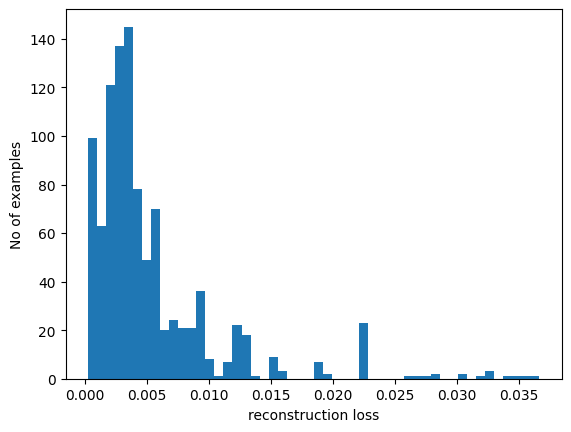

In [8]:
# Validation reconstruction loss
val_reconstruction_loss = ad.get_reconstruction_loss(CAE, val_frames, plot_reconstruction_loss=True)

##### Option 1: Validation is labeled

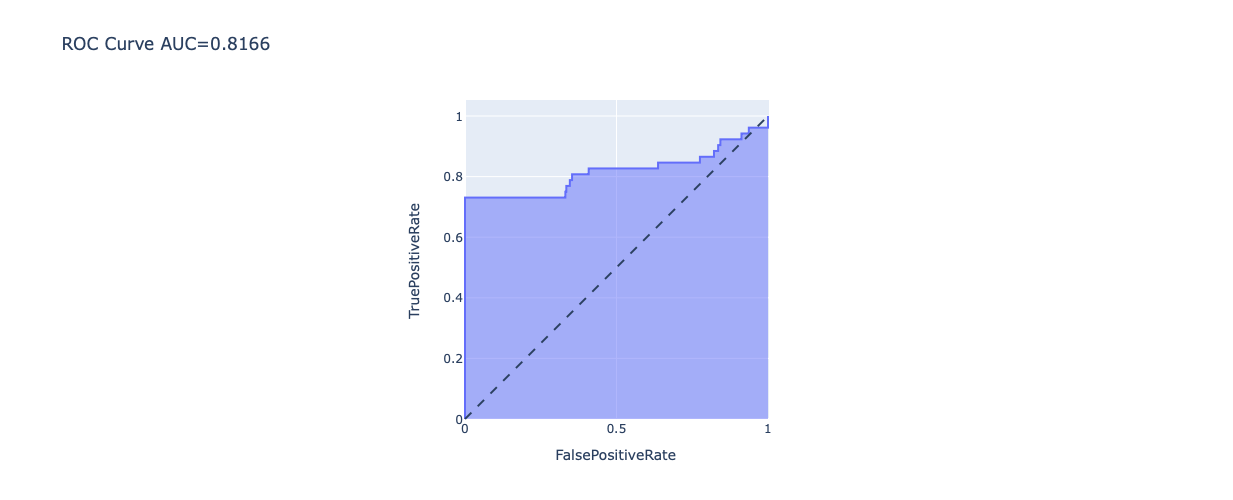


Threshold=0.022350184619426727


In [9]:
threshold = ad.get_threshold_by_roc_auc(val_target, val_reconstruction_loss, plot_roc_auc_curve=True)

##### Option 2: Validation is un-labeled

In [34]:
threshold = ad.get_threshold_by_loss_distribution(val_reconstruction_loss, quantile=0.99)


Threshold=0.028579363953322154


### Evaluate Performance

32/32 [==============================] - 15s 468ms/step


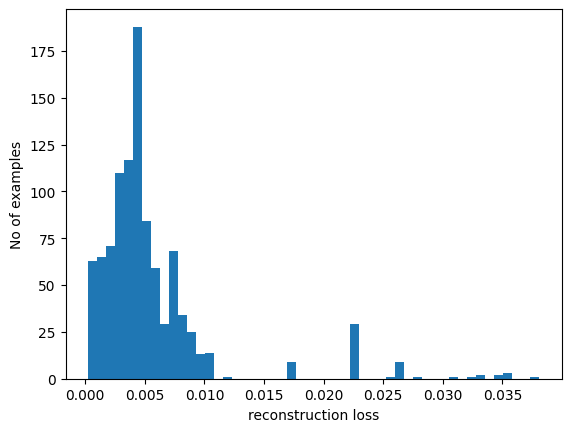

In [10]:
# Test reconstruction loss
test_reconstruction_loss = ad.get_reconstruction_loss(CAE, test_frames, plot_reconstruction_loss=True)
# Test Predictions by threshold
test_pred = ad.predict(test_reconstruction_loss, threshold)

Noise Detection Metrics:

Precision: 0.653
Recall: 0.667
F1-score: 0.660
Support: 48
------------
 Error Analysis:


Recall per Noise Type:



noise_type  recall
0            white_noise     1.0
1               gaussian     1.0
2  left_half_white_noise     0.0


Noise Type Distribution over test:



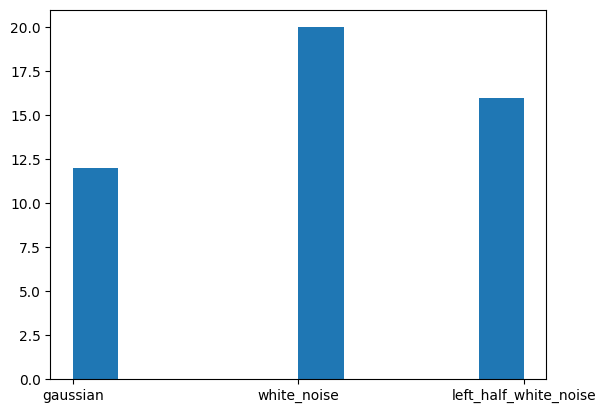

In [15]:
evaluate.evaluate_model(test_target, test_pred, test_noise_types)

# WIP
## Option 2: Convolutional-LSTM AE
   
    Using Conv layers convert input images to 1D arrays to feed into an LSTM AE

In [4]:
ConvLSTMAE = models.get_model('ConvLSTMAE', load_model=False)

In [5]:

callbacks = [
    # saves the model's weights
    tf.keras.callbacks.ModelCheckpoint(
        filepath=conf.MODELS_PATHS.get('ConvLSTMAE'),
        save_weights_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", # Stop training when `val_loss` is no longer improving
        min_delta=1e-2, # "no longer improving" being defined as "no better than 1e-2 less"
        patience=2, # "no longer improving" being further defined as "for at least 2 epochs"
        verbose=1,
    )
]
ConvLSTMAE_history = ConvLSTMAE.fit(train_frames, train_frames,
                      epochs=1,
                      batch_size=64,
                      validation_data=(val_frames, val_frames),
                      callbacks=callbacks
                      )


1/1 [==============================] - 1140s 1140s/step - loss: 0.2353 - val_loss: 0.5310
